# Task To Do 
#Extract the Following information fromt he Given Image
1. Group information for the entities Bill To, Ship To, Invoice, Invoice date, P. O. and Due date
2. Extract table data in csv format or xls format
3. Extract Handwritten signature from Invoice 

In [1]:
# installing the pre-trained text detection algorithm
!pip install https://github.com/myhub/tr/archive/1.5.1.zip
!pip install imutils

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
     | 177.5 MB 54.0 MB/s 0:00:24
  Preparing metadata (setup.py) ... - done
  Created wheel for tr: filename=tr-1.5.0-py3-none-any.whl size=162900369 sha256=23e5525434037b12fba9b69aef8a098ce103b8e7ef1131951df4b5a04ad1278e
  Stored in directory: /tmp/pip-ephem-wheel-cache-1p62ff5a/wheels/e8/24/f6/fa325b41760077cc82fdb1745a4cb3ef7f6ac8fd8c5f37e6f2
Successfully built tr
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
  Preparing metadata (setup.py) ... - done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25858 sha256=5a707f609f71bf30a8f5356846765cd69e36e8b69aa34fe2f0ca7c4b99f35171
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils


In [2]:
from tr import *
from PIL import Image, ImageDraw, ImageFont
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering
import imutils
import cv2

# tr 1.5.0 https://github.com/myhub/tr


In [3]:
# Signature Extraction from the IMage
def Signature_extraction(img_path):
    image = cv2.imread(img_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #gray = image

    # initialize a rectangular kernel that is ~5x wider than it is tall,
    # then smooth the image using a 3x3 Gaussian blur and then apply a
    # blackhat morphological operator to find dark regions on a light
    # background
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    gray = cv2.GaussianBlur(gray, (3, 3), 0)
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    #plt.imshow(blackhat)
    # compute the Scharr gradient of the blackhat image and scale the
    # result into the range [0, 255]
    grad = cv2.Sobel(blackhat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
    grad = np.absolute(grad)
    #plt.imshow(grad)

    (minVal, maxVal) = (np.min(grad), np.max(grad))
    grad = (grad - minVal) / (maxVal - minVal)
    grad = (grad * 255).astype("uint8")
    #plt.imshow(grad)

    # apply a closing operation using the rectangular kernel to close
    # gaps in between characters, apply Otsu's thresholding method, and
    # finally a dilation operation to enlarge foreground regions
    grad = cv2.morphologyEx(grad, cv2.MORPH_CLOSE, kernel)
    thresh = cv2.threshold(grad, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    thresh = cv2.dilate(thresh, None, iterations=6)
    #plt.imshow(thresh)

    # find contours in the thresholded image and grab the largest one,
    # which we will assume is the stats table
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    tableCnt = max(cnts, key=cv2.contourArea)
    # compute the bounding box coordinates of the stats table and extract
    # the table from the input image
    (x, y, w, h) = cv2.boundingRect(tableCnt)
    
    # extraction of signature from the image and saving to a png file
    Signature = image[y:y + h, x:x + w].copy()
    sign_path = '/kaggle/working/Signature.png'
    plt.imsave(sign_path,Signature)
    
    image[y:y + h, x:x + w] = np.ones(Signature.shape)*255
    
    img_path = '/kaggle/working/invoice.png'
    plt.imsave(img_path,image)
    
    return img_path,sign_path

In [4]:
# text detection function from a given image 
def img_to_text(img_path):
    
    #Image Preprocessing 
    
    img_pil = Image.open(img_path)
    MAX_SIZE = 2000
    
    #image Resize to limit the max size to a certain limit
    if img_pil.height > MAX_SIZE or img_pil.width > MAX_SIZE:
        scale = max(img_pil.height / MAX_SIZE, img_pil.width / MAX_SIZE)

        new_width = int(img_pil.width / scale + 0.5)
        new_height = int(img_pil.height / scale + 0.5)
        img_pil = img_pil.resize((new_width, new_height), Image.BICUBIC)

    
    # Convert the IMage to gray image 
    gray_pil = img_pil.convert("L")

    # Text Detection in the IMage
    rect_arr = detect(img_pil, FLAG_RECT)

    # Initiate an empty image to recreate the text alone
    img_draw = ImageDraw.Draw(img_pil)
    colors = ['green']

    # rewite the Image with Appropriate text
    for i, rect in enumerate(rect_arr):
        x, y, w, h = rect
        img_draw.rectangle( (x, y, x + w, y + h),
                            outline=colors[i % len(colors)],
                            width=4
                          )

    return img_pil,gray_pil


# this shows detected text and it’s location on the image
def detected_text_on_image(gray_pil):
    blank_pil = Image.new("L", img_pil.size, 255)
    blank_draw = ImageDraw.Draw(blank_pil)

    results = run(gray_pil)
    for line in results:
        x, y, w, h = line[0]
        txt = line[1]
        font = ImageFont.truetype("/kaggle/input/ocr-test/msyh.ttf", max(int(h * 0.6), 14))
        blank_draw.text(xy=(x, y), text=txt, font=font)

    return blank_pil

def print_detected_text(gray_pil):
    
    # To view the Predictions fromt he Given IMage
    results = run(gray_pil)
    rslt = ""
    for line in results:
        x, y, w, h = line[0]
        txt = line[1]
        rslt = rslt + " " + txt
        print(line[0])
        print(line[1])
        print("=================================")

    return

In [5]:
# bill and Item iternary information extrcation from the predicted text info

def Bill_item_info_cluster_extraction(gray_pil):
    # predictions on the gray image with run method from installed pre-trained Model
    results = run(gray_pil)
    #intialising the variables
    Y_mean = []
    Bbox = []
    Text = []
    # iterating over the predictions
    for predct in results:
        txt = predct[1]
        Text.append(txt)

        x, y, w, h = predct[0]
        Y_mean.append(np.array([y+(h/2)]))
        Bbox.append([x, y, w, h])


    Y_mean = np.array(Y_mean)
    df_clusters = pd.DataFrame(Text, columns = ['Text'])
    df_clusters['Y_mean'] = Y_mean

    # data frame for ['x','y','w','h'] values
    df_Bbox = pd.DataFrame(Bbox,columns = ['x','y','w','h'])
    df_clusters = pd.concat([df_clusters,df_Bbox],axis=1)

    # randomly chosen dataset
    X = Y_mean  #np.array(list(Y_cluster.values()))

    # here we need to mention the number of clusters
    # otherwise the result will be a single cluster
    # containing all the data
    # Number of clusters based on the obesrvation and text distributions in the image
    clustering = AgglomerativeClustering(n_clusters = 4).fit(X)

    df_clusters['Y_clusters'] = clustering.labels_

    df_ygroups = df_clusters.groupby('Y_clusters')

    for i in range(4):
        txt_cluster = df_clusters.iloc[df_ygroups.groups[i]].Text.values

        if 'Bill To' in txt_cluster:
            df_bill = df_clusters.loc[df_ygroups.groups[i]]
        elif 'QTY' in txt_cluster:
            df_items = df_clusters.loc[df_ygroups.groups[i]]
        else:
            1

    return df_bill,df_items

In [6]:
def Billing_info_extraction(df_bill):    
    df_bill['X_mean'] = np.array(df_bill['x']+df_bill['w']/2)
    df_bill

    Xmn = []
    for i in df_bill['X_mean'].values:
        Xmn.append(np.array([i]))

    Xmn = np.array(Xmn)

    # randomly chosen dataset
    X = Xmn  #np.array(list(Y_cluster.values()))

    # here we need to mention the number of clusters
    # otherwise the result will be a single cluster
    # containing all the data
    clustering = AgglomerativeClustering(n_clusters = 4).fit(X)

    df_bill['X_cluster'] = clustering.labels_
    #df_bill.sort_values('X_cluster',ascending=True,inplace=True)

    df_bill_Xcluster = df_bill.groupby('X_cluster')

    Bill_info = {}
    for i in range(4):
        txt_cluster = df_bill.loc[df_bill_Xcluster.groups[i]]['Text'].values

        if 'Bill To' in txt_cluster:
            Bill_info[txt_cluster[0]] = txt_cluster[1:]
        elif 'Ship To' in txt_cluster:
            Bill_info[txt_cluster[0]] = txt_cluster[1:]
        elif 'P.O.#' in txt_cluster:
            Invoice = txt_cluster
        else:
            dat = txt_cluster

    for i in range(len(Invoice)):
        Bill_info[Invoice[i]] = dat[i]

    return Bill_info

In [7]:
def iternary_pricing_table(df_items):
    df_items['X_max'] = np.array(df_items['x']+df_items['w'])

    X_max = []
    for i in df_items['X_max'].values:
        X_max.append(np.array([i]))

    X_max = np.array(X_max)

    # randomly chosen dataset
    X = X_max  #np.array(list(Y_cluster.values()))

    # here we need to mention the number of clusters
    # otherwise the result will be a single cluster
    # containing all the data
    clustering = AgglomerativeClustering(n_clusters = 4).fit(X)

    df_items['X_cluster'] = clustering.labels_

    df_items.sort_values('X_cluster',ascending=True,inplace=True)
    df_items_Xcluster = df_items.groupby('X_cluster')


    for i in range(4):
        txt_cluster = df_items.loc[df_items_Xcluster.groups[i]].sort_values('y').Text.values

        if 'QTY' in txt_cluster:
            df_qty = pd.DataFrame(txt_cluster)
        elif 'UNIT PRICE' in txt_cluster:
            df_Uprice = pd.DataFrame(txt_cluster)
        elif 'AMOUNT' in txt_cluster:
            df_amnt = pd.DataFrame(txt_cluster)
        else:
            df_desc = pd.DataFrame(txt_cluster)


    items_table = pd.concat([df_qty,df_desc,df_Uprice,df_amnt], axis=1)
    
    items_table.fillna('___',inplace=True)
    items_table.columns = items_table.loc[0]
    items_table = items_table.loc[1:]

    return items_table

In [8]:
# Main Function
def Main(img_path):
    
    img_path,sign_path = Signature_extraction(img_path)
    
    # Takes image path as input and returns the text predictions on the image
    img_pil,gray_pil = img_to_text(img_path)
    
    # Extracted text from a string
    #detected_text_on_image(gray_pil)
    
    # to visuavalise the printed text fromt he Image
    #print_detected_text(gray_pil)
    
    # extracting df_bill,df_items from the predicted text information
    df_bill,df_items = Bill_item_info_cluster_extraction(gray_pil)
    
    # Billing info Extraction Process
    Bill_info_dct = Billing_info_extraction(df_bill)
    
    price_table = iternary_pricing_table(df_items)
    
    return Bill_info_dct, price_table, sign_path

# Main Function

In [9]:
img_path = '/kaggle/input/invoice-sample/invoice-template-in-classic-white-750px.png'

In [10]:
img_path = '/kaggle/input/invoice-sample/invoice-template-in-classic-white-750px.png'
Bill_info_dct, price_table, sign_path = Main(img_path)

In [11]:
Bill_info_dct

{'Ship To': array(['Kavindra Mannan', '264,Abdul Rehman', 'Mumbai,Bihar 40009'],
       dtype=object),
 'Bill To': array(['Kavindra Mannan', '27,Dlf City,Gupta', 'Delhi,Delhi 40003'],
       dtype=object),
 'lnvoice#': 'IN-001',
 'Invoice Date': '29/01/2019',
 'P.O.#': '2430/2019',
 'Due Date': '26/04/2019'}

In [12]:
price_table

,QTY,DESCRIPTION,UNIT PRICE,AMOUNT
1,1,Frontend design restructure,"9,999.00","9,999.00"
2,2,Custom icon package,975.00,"1,950.00"
3,3,Gandhi mouse pad,99.00,297.00
4,___,___,Subtotal,"12,246.00"
5,___,___,GST 12.0%,"1,469.52"
6,___,___,TOTAL,"※13,715.52"


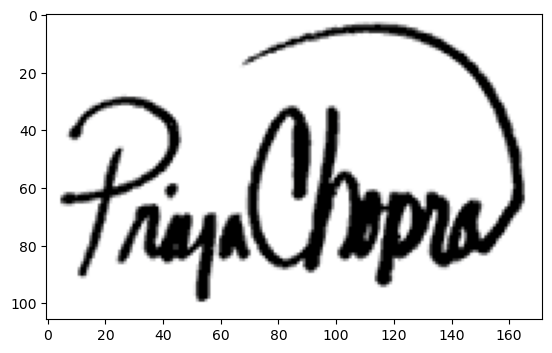

In [13]:
sign = plt.imread(sign_path)
plt.imshow(sign)

# Visualisation of the Results

In [14]:
#image path as input to the processing code
img_path = '/kaggle/input/invoice-sample/invoice-template-in-classic-white-750px.png'

In [15]:
#signature extraction from the image
img_path,sign_path = Signature_extraction(img_path)

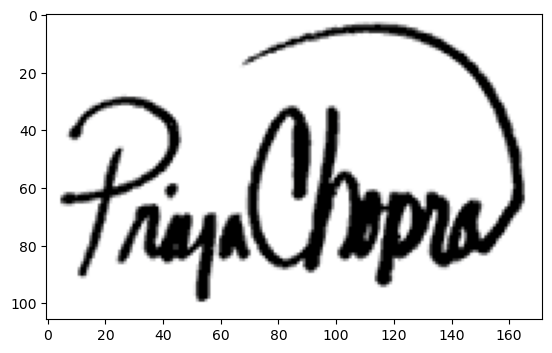

In [16]:
# Signature view
plt.imshow(plt.imread(sign_path))

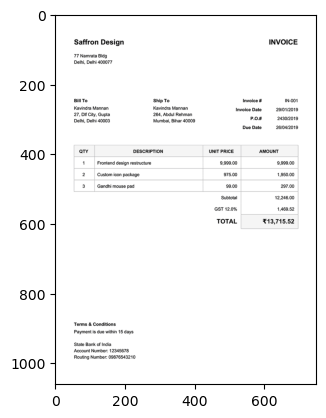

In [17]:
# processed image without Signature
plt.imshow(plt.imread(img_path))

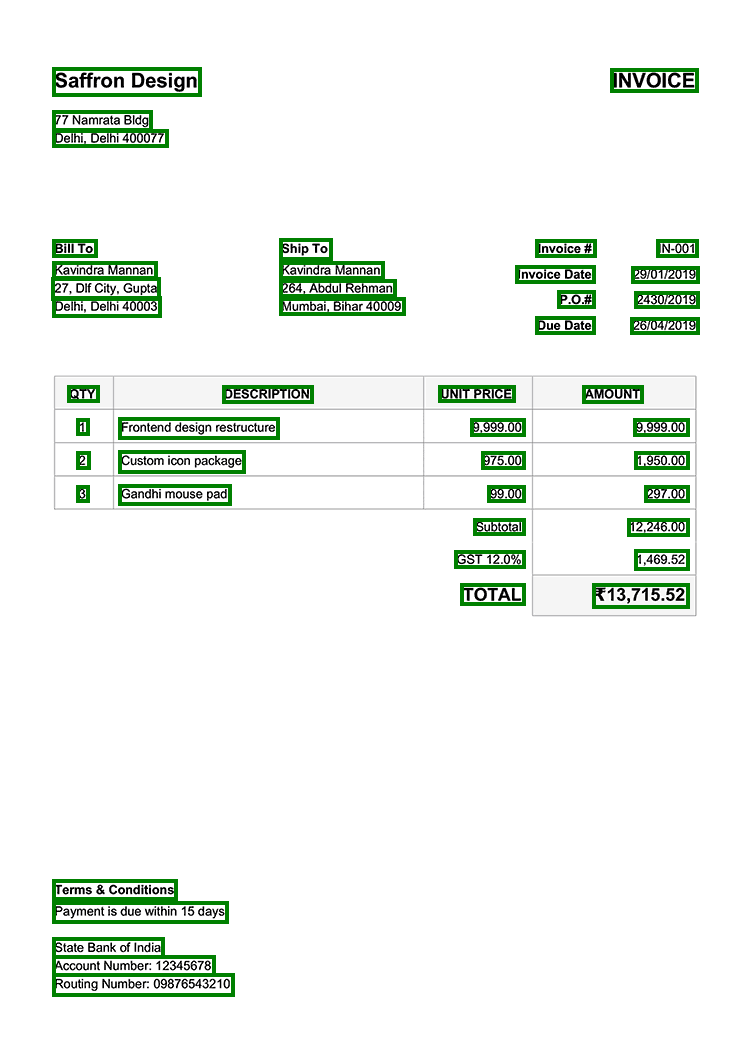

In [18]:
# TExt prediction fromt he given image
img_pil,gray_pil = img_to_text(img_path)
img_pil

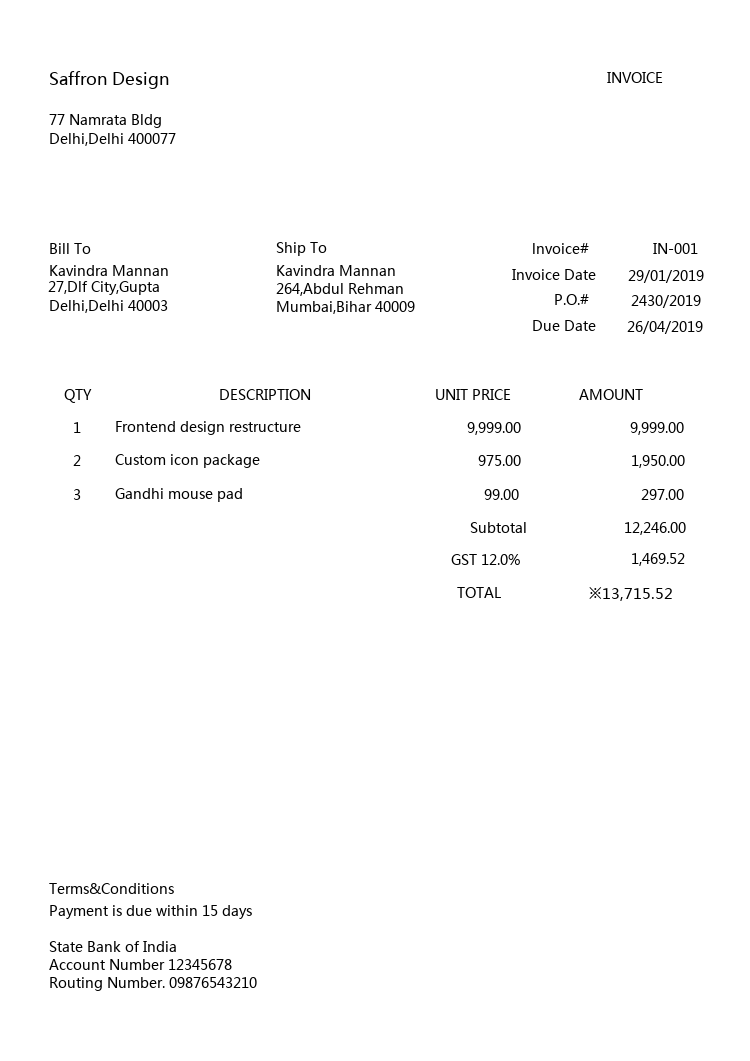

In [19]:
# Extracted text from a string
detected_text_on_image(gray_pil)

In [20]:
# to visuavalise the printed text fromt he Image
print_detected_text(gray_pil)

(49, 67, 155, 29)
Saffron Design
(607, 68, 94, 24)
INVOICE
(49, 110, 106, 21)
77 Namrata Bldg
(49, 129, 122, 18)
Delhi,Delhi 400077
(49, 239, 51, 18)
Bill To
(276, 238, 59, 22)
Ship To
(532, 239, 67, 18)
lnvoice#
(653, 239, 48, 18)
IN-001
(49, 261, 111, 18)
Kavindra Mannan
(276, 261, 111, 18)
Kavindra Mannan
(512, 265, 86, 18)
Invoice Date
(628, 266, 74, 17)
29/01/2019
(48, 277, 115, 23)
27,Dlf City,Gupta
(276, 279, 123, 18)
264,Abdul Rehman
(49, 296, 115, 21)
Delhi,Delhi 40003
(276, 297, 132, 18)
Mumbai,Bihar 40009
(554, 290, 44, 18)
P.O.#
(631, 291, 71, 17)
2430/2019
(532, 316, 66, 18)
Due Date
(627, 317, 75, 17)
26/04/2019
(64, 385, 38, 17)
QTY
(219, 385, 97, 18)
DESCRIPTION
(435, 385, 83, 17)
UNIT PRICE
(579, 385, 67, 18)
AMOUNT
(73, 418, 19, 17)
1
(115, 417, 167, 22)
Frontend design restructure
(467, 418, 61, 18)
9,999.00
(630, 418, 62, 18)
9,999.00
(73, 451, 20, 18)
2
(115, 450, 133, 23)
Custom icon package
(478, 451, 50, 18)
975.00
(631, 451, 61, 18)
1,950.00
(73, 485, 19, 17)
3

In [21]:
# extracting df_bill,df_items from the predicted text information
df_bill,df_items = Bill_item_info_cluster_extraction(gray_pil)

In [22]:
# bill info extracted from the image invoice
df_bill

,Text,Y_mean,x,y,w,h,Y_clusters
4,Bill To,248.0,49,239,51,18,2
5,Ship To,249.0,276,238,59,22,2
6,lnvoice#,248.0,532,239,67,18,2
7,IN-001,248.0,653,239,48,18,2
8,Kavindra Mannan,270.0,49,261,111,18,2
9,Kavindra Mannan,270.0,276,261,111,18,2
10,Invoice Date,274.0,512,265,86,18,2
11,29/01/2019,274.5,628,266,74,17,2
12,"27,Dlf City,Gupta",288.5,48,277,115,23,2
13,"264,Abdul Rehman",288.0,276,279,123,18,2


In [23]:
# item price info
df_items

,Text,Y_mean,x,y,w,h,Y_clusters
20,QTY,393.5,64,385,38,17,0
21,DESCRIPTION,394.0,219,385,97,18,0
22,UNIT PRICE,393.5,435,385,83,17,0
23,AMOUNT,394.0,579,385,67,18,0
24,1,426.5,73,418,19,17,0
25,Frontend design restructure,428.0,115,417,167,22,0
26,"9,999.00",427.0,467,418,61,18,0
27,"9,999.00",427.0,630,418,62,18,0
28,2,460.0,73,451,20,18,0
29,Custom icon package,461.5,115,450,133,23,0


# Bill Info Clustering 
1. Group information for the entities Bill To, Ship To, Invoice, Invoice date, P. O. and Due date

In [24]:
# Billing info Extraction Process
Bill_info_dct = Billing_info_extraction(df_bill)
Bill_info_dct

{'Ship To': array(['Kavindra Mannan', '264,Abdul Rehman', 'Mumbai,Bihar 40009'],
       dtype=object),
 'Bill To': array(['Kavindra Mannan', '27,Dlf City,Gupta', 'Delhi,Delhi 40003'],
       dtype=object),
 'lnvoice#': 'IN-001',
 'Invoice Date': '29/01/2019',
 'P.O.#': '2430/2019',
 'Due Date': '26/04/2019'}

# Items and Prices - Iternary info extractions

In [25]:
tbl = iternary_pricing_table(df_items)
tbl

,QTY,DESCRIPTION,UNIT PRICE,AMOUNT
1,1,Frontend design restructure,"9,999.00","9,999.00"
2,2,Custom icon package,975.00,"1,950.00"
3,3,Gandhi mouse pad,99.00,297.00
4,___,___,Subtotal,"12,246.00"
5,___,___,GST 12.0%,"1,469.52"
6,___,___,TOTAL,"※13,715.52"


# Export the table to a csv file 

In [26]:
tbl.to_csv('/kaggle/working/items_price.csv', index=None)
#tbl.to_excel('/kaggle/working/items_price.xlsx')

In [27]:
table = pd.read_csv('/kaggle/working/items_price.csv')
table

,QTY,DESCRIPTION,UNIT PRICE,AMOUNT
0,1,Frontend design restructure,"9,999.00","9,999.00"
1,2,Custom icon package,975.00,"1,950.00"
2,3,Gandhi mouse pad,99.00,297.00
3,___,___,Subtotal,"12,246.00"
4,___,___,GST 12.0%,"1,469.52"
5,___,___,TOTAL,"※13,715.52"
